# Домашнее задание №6

Задание выполнил(а): `Сетдеков Кирилл`

### Общая информация

__Дата выдачи:__ 12.07.2021

__Дедлайн:__ 26.07.2021 23:30



### О задании

Часть 1 содержит практическое задание на применение метода главных компонент.

Часть 2 содержит практическое задание на применение метода One-Class SVM.


### Оценивание и штрафы


#### 1. Метод главных компонент [5 баллов]
* [Задание 1](#task1) [2 балла]
* [Задание 2](#task2) [2 балл]
* [Задание 3](#task3) [1 балл]

#### 2. One-Class SVM [5 баллов]
* [Задание 1](#task2_1) [1 балл]
* [Задание 2](#task2_2) [1 балл]
* [Задание 3](#task2_3) [3 балла]

Итоговая оценка за домашнюю работу равна сумме набранных баллов.

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 0.25 балла в день (от оценки в 10 бальной шкале), но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/course/811). 

In [164]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

np.random.seed(0)

Imports

In [165]:
import requests
import math

from sklearn.decomposition import PCA


# Часть 1. Детектирование аномалий на основе метода главных компонент
В файле Abilebe.mat представлены данные о трафике (количество байт в единицу времени) в сети Abilene для трех недель. Загрузим данные и посмотрим на ключи словаря.

In [166]:
abline_url = 'https://github.com/ksetdekov/ml_dpo_2021/blob/3f13b2deb97680a8c6b4632af6b3f0eaeb4f3856/hw/hw6/Abilene.mat?raw=true'
r = requests.get(abline_url, allow_redirects=True)

open('Abilene.mat', 'wb').write(r.content)



5888856

In [167]:
data = io.loadmat('Abilene.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'odnames', 'X2', 'utc2', 'X3', 'utc3', 'X4', 'utc4'])

Словарь содержит:
+ матрицы X2, X3 и X4 с информацией о трафике между 121 парами “адресат-получатель” для каждой из трех недель
+ odnames с названиями всех пар “адресат-получатель”
+ вектора utc2; utc3, и utc4, содержащие моменты времени в формате UTC (в секундах), для которых были измерены значения трафика между рассмотренными парами “адресат-получатель”

Нас интересует информация о трафике: хотелось бы реагировать на аномальные события в сети. Давайте попробуем оценить визуально.

In [168]:
X2 = data['X2']
X3 = data['X3']
X4 = data['X4']

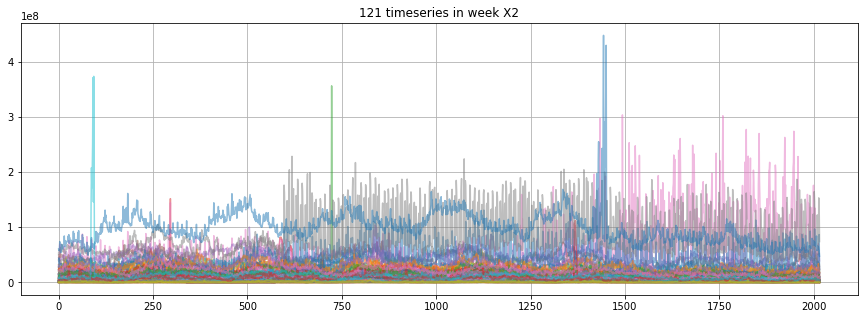

In [169]:
plt.figure(figsize=(15,5))
plt.plot(X2, alpha=0.5);
plt.title('121 timeseries in week X2')
plt.grid(True)

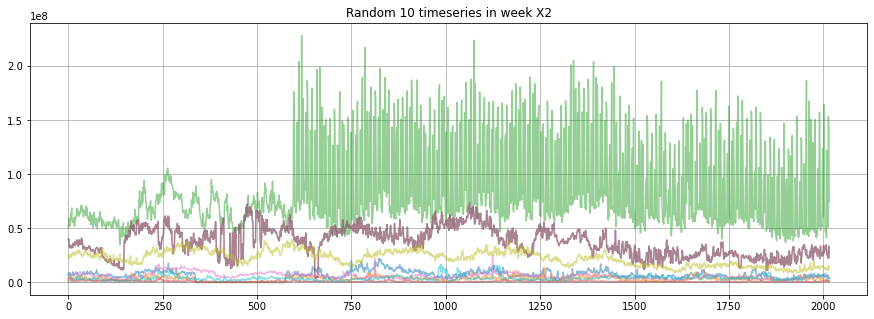

In [170]:
idx = np.random.randint(0, 121, 10)
plt.figure(figsize=(15,5))
plt.plot(X2[:,idx], alpha=0.5);
plt.title('Random 10 timeseries in week X2')
plt.grid(True)

У нас слишком много рядов (высокая размерность данных 121) и их диапозоны значений довольно разные! Однако, видна какая-то структура. Это дает надежду на успешное снижение размерности задачи методом главных компонент. Предлагается использовать следующий алгоритм:
1. Оценить операторы сжатия и восстановления по компонентам второй недели (тренеровочная выборка)
2. Критерий аномальности наблюдения: слишком большая ошибка восстановления после сжатия 

### Задание 1 [2 балла] <a id="task1"></a>
Вспомнить детали реализации алгоритма главных компонент (https://arxiv.org/pdf/1404.1100.pdf) и получить оператор сжатия.

Оценки будут производиться по главным компонентам **второй** недели

In [171]:
X2_mean = np.mean(X2, axis=0)
X2_demeaned = X2 - X2_mean
U, s, V = np.linalg.svd(X2_demeaned.T, full_matrices=False)
# X2_based_pc =np.dot(U, np.diag(s))
X2_based_pc = U

Подсчитаем метрику $\rho := $ какую долю дисперсии данных в каждую из трех недель (по отдельности) объясняют первые $d$ главных компонент, оценненые по первой неделе. 

Пусть 
 - $X$ матрица $121 \times 2016$ для которой нужно оценить такую метрику
 - $\overline{X}$ вектор средних по строкам
 - $U$ первые $d$ главных компонент, оценненые по первой неделе
 - $Z(X) = U^T(X2 - \overline{X2})$ преобразование сжатия 
 
Тогда 

$$
\rho(X) = \dfrac{\operatorname{trace}(Z - \overline{Z})(Z - \overline{Z})^T}{\operatorname{trace}(X - \overline{X})(X - \overline{X})^T} 
$$
 

Преобразование сжатия:

In [172]:
def compression_operator(X, mean_pc, based_pc, number_pc):
    U_tr = based_pc[:,:number_pc]
    res = U_tr.T @ (X-mean_pc).T
    return res

def rho(X, mean_pc, based_pc, number_pc):
    Z = compression_operator(X, mean_pc, based_pc, number_pc)

    if number_pc == 1:
        explained_var = np.cov(Z)

    else:        
        explained_var = np.trace(np.cov(Z))

    total_var = np.trace(np.cov(X.T))

    return explained_var / total_var

Проверим, сравнив со значением, которое для $\rho$ считает sklearn PCA

In [173]:
mynerho = rho(X2,X2_mean, U, 1)

dec = PCA()
dec.fit(X2) # обучаем PCA
pcdrho = dec.explained_variance_ratio_[0]

#compare the closeness of two values
print(f'My rho value for 1 PC {mynerho} and sklearn PCA value is {pcdrho}')
print(f'Are they close?: {math.isclose(mynerho,pcdrho)}')

My rho value for 1 PC 0.29712471536276425 and sklearn PCA value is 0.2971247153627641
Are they close?: True


### Задание 2 [2 балла] <a id="task2"></a>
Подсчитать, какую долю дисперсии данных в каждую из трех
недель (по отдельности) объясняют первые d главных компонент (график зависимости $\rho$ от d), если главные компоненты были оценены по данным первой недели.

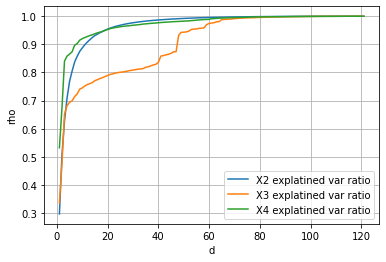

In [174]:
X2_var = plt.plot(range(1,122), [rho(X2,X2_mean, U, i) for i in range(1,122)], label='X2 explatined var ratio')
X3_var =  plt.plot(range(1,122), [rho(X3,X2_mean, U, i) for i in range(1,122)], label='X3 explatined var ratio')
X4_var =  plt.plot(range(1,122), [rho(X4,X2_mean, U, i) for i in range(1,122)], label='X4 explatined var ratio')

plt.legend(loc='best')
plt.axis('tight');
plt.grid();
plt.xlabel("d")
plt.ylabel("rho")
plt.show()

Выпишем преобразование восстановления для $X$:

$$\hat{X} = \overline{X2} + UZ(X)$$

где $Z(X)$ - преобразование сжатия из прошлого задания.

In [175]:
def decompression_operator(compressed_X, mean_pc, based_pc, number_pc):
    Z = compression_operator(compressed_X, mean_pc, based_pc, number_pc)
    U = based_pc[:,:number_pc]

    return mean_pc + (U @ Z).T
  

In [176]:
def residual_matrix(X, mean_pc, based_pc, number_pc):
    return X-decompression_operator(X,mean_pc, based_pc, number_pc)

### Задание 3 [2 балла] <a id="task3"></a>
Нарисовать график зависимости статистики $Q = (x - \hat x)^T(x - \hat x)$ ( https://www.ltu.se/cms_fs/1.51590!/pca_part%201_jackson_1980.pdf, интересующая формула: 31) от времени для каждой из трех недель по отдельности, при этом главные компоненты оценивать по данным первой недели, параметр d выбрать по результатам анализа зависимости доли диперсии от значения d для данных первой
недели.

*Заметим*: Статистика $Q$ тогда в момент времени $t$ это квадрат нормы строки $t$ матрицы $X-\hat{X}$

In [177]:
def q_stat(residuals, moment):
    return(residuals[moment].T @ residuals[moment])

Зафиксируем число компонет, с которым будем работать:

In [178]:
def broken_stick_pc_number_select(X):
    X_mean = np.mean(X, axis=0)
    U, s, V = np.linalg.svd(X - X_mean, full_matrices=False)
    
    s = s ** 2 / float(np.sum(s ** 2))
    broken_stick = np.array([np.sum(1.0 / np.arange(1, 122)[i:]) for i in range(121)]) / 121.0
    return s > broken_stick

In [179]:
broken_stick_pc_number_select(X2)

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [180]:
print(f'будем брать {sum(broken_stick_pc_number_select(X2))} главных компонент')

будем брать 7 главных компонент


Выберем сколько будем использовать главных компонент матрицы $X2$. Посмотрим, сколько процентов дисперсии в $X2$ неделе они объясняют:

In [181]:
pc_const = sum(broken_stick_pc_number_select(X2))
np.sum(s[:pc_const] ** 2) / float(np.sum(s ** 2))

0.8374392213328566

Рассчитаем матрицу остатков для каждой из недели:

In [182]:
X2_resid = residual_matrix(X2, X2_mean, U, pc_const)
X3_resid = residual_matrix(X3, X2_mean, U, pc_const)
X4_resid = residual_matrix(X4, X2_mean, U, pc_const)

### Задание 4 [2 балла] <a id="task4"></a>
Теперь достаточно объявлять тревого для наблюдения с "большим" полученным остатком (ошибкой восстановления). Однако, здесь требуется уточнить, что такое "большим"?
Один из возможных подходов к определению этого уровня статистически, предполагая нормальное распределение рассчитываемой статистики, нам остается задать уровень значимости $\alpha$. Расчет статистики реализован в функции q_critical. Математические детали можно прочитать здесь: ( https://www.ltu.se/cms_fs/1.51590!/pca_part%201_jackson_1980.pdf, интересующая формула: 33).  

Вам необходимо взять параметр $\alpha$ равным 0.05 и 0.01, привести на рисунках значение попрога $Q_\alpha$ (изобразив константной линией) и рассчитать число аномалий для каждой недели.

In [183]:
def q_critical(X, number_pc, alpha):
    X_mean = X.mean(axis=0)
    
    w, v = np.linalg.eig(np.cov((X - X_mean).T))
    l = -np.sort(-w)[number_pc:]
    
    theta_one = sum(l)
    theta_two = sum(l ** 2)
    theta_three = sum(l ** 3)

    h = 1 - (2 * theta_one * theta_three) / (3 * theta_two ** 2)
    
    if h > 0:
        c_alpha = stats.norm.ppf(1 - alpha) 
    else:
        c_alpha = stats.norm.ppf(alpha) 
        
    inside_brackets =  (c_alpha * np.sqrt(2 * theta_two * h ** 2)) / (theta_one) + (theta_two * h * (h - 1)) / (theta_one ** 2) + 1
    
    return theta_one * np.power(inside_brackets, 1/h) 

Добавим критические значения статистики и рассмотим график для каждой недели отдельно:

In [184]:
def q_plot(X, X_resid, number_pc):
    f, axarr = plt.subplots(2, sharex=True, figsize=(40, 15))
    
    axarr[0].set_yscale('log')
    axarr[0].plot([q_stat(X_resid, t) for t in range(2016)])
    axarr[0].axhline(y=q_critical(X, number_pc, 0.01) , xmin=0, xmax=2016, linewidth=2, color = 'r')
    axarr[0].axhline(y=q_critical(X, number_pc, 0.05) , xmin=0, xmax=2016, linewidth=2, color = 'g')
    axarr[0].axis('tight')
    
    axarr[1].plot(X);
    axarr[1].axis('tight')

Выведем графики остатков c линиями $Q_{\alpha}$ (в логарифмической шкале)  и графики процессов (ocь времени совпадет):

### Для недели $X2$

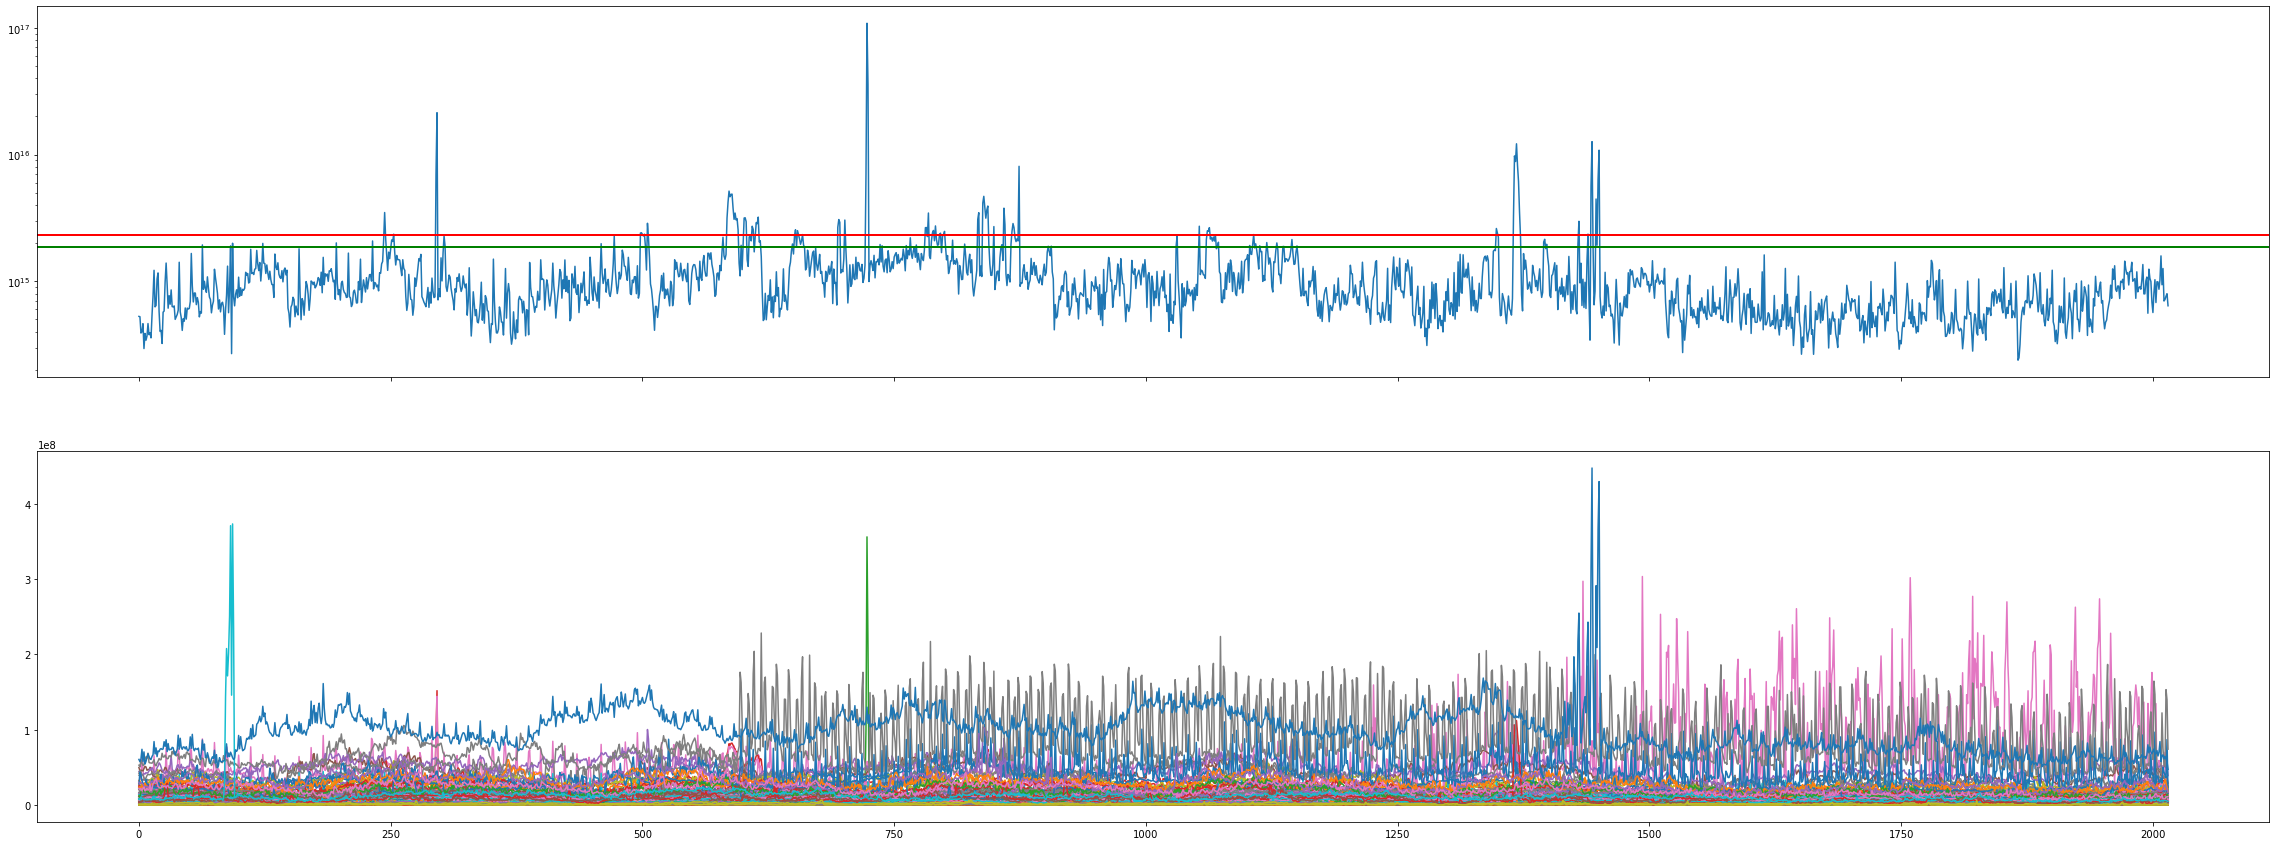

In [185]:
q_plot(X2, X2_resid, 7)

Число выбросов для $\alpha = 0.01$

In [186]:
np.sum([q_stat(X2_resid, t) for t in range(2016)] > q_critical(X2, 7, 0.01))

86

Число выбросов для $\alpha = 0.05$

In [187]:
np.sum([q_stat(X2_resid, t) for t in range(2016)] > q_critical(X2, 7, 0.05))

173

### Для недели $X3$

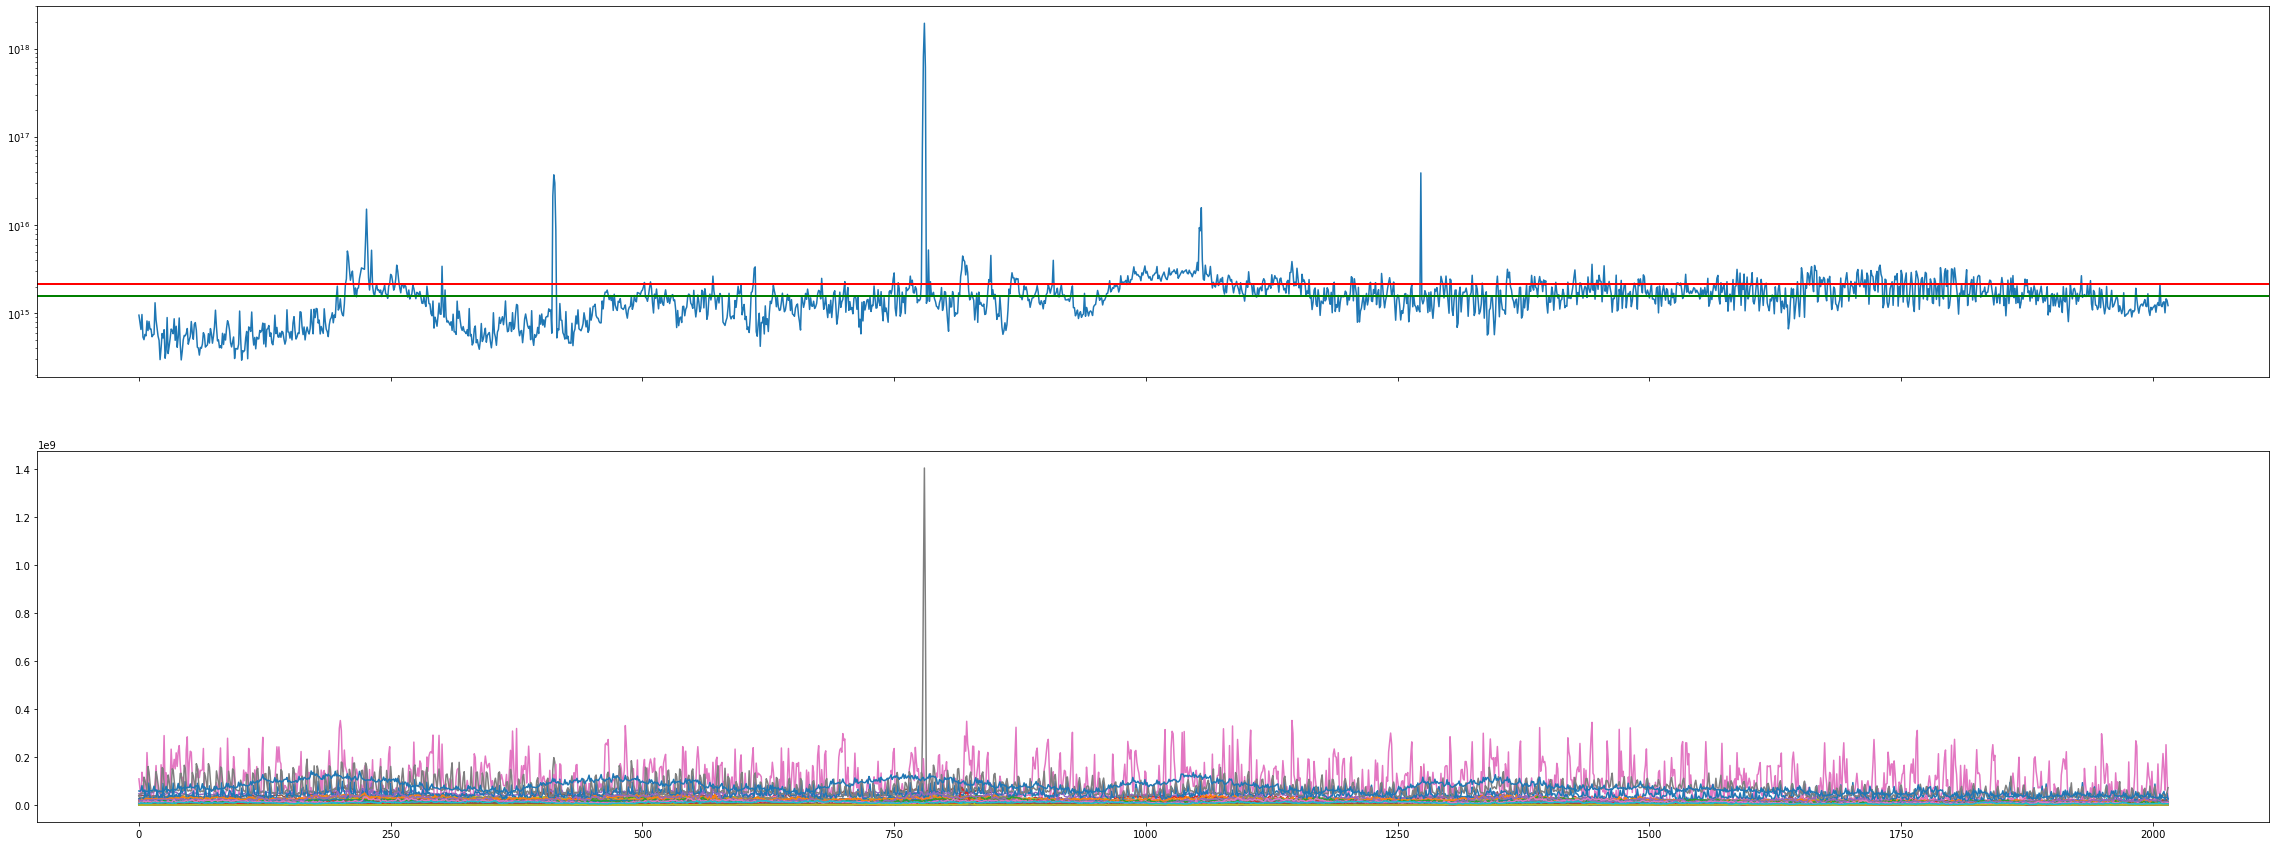

In [188]:
q_plot(X3, X3_resid, 7)

Число выбросов для $\alpha = 0.01$

In [189]:
np.sum([q_stat(X3_resid, t) for t in range(2016)] > q_critical(X3, 7, 0.01))

376

Число выбросов для $\alpha = 0.05$

In [190]:
np.sum([q_stat(X3_resid, t) for t in range(2016)] > q_critical(X3, 7, 0.05))

911

### Для недели $X4$

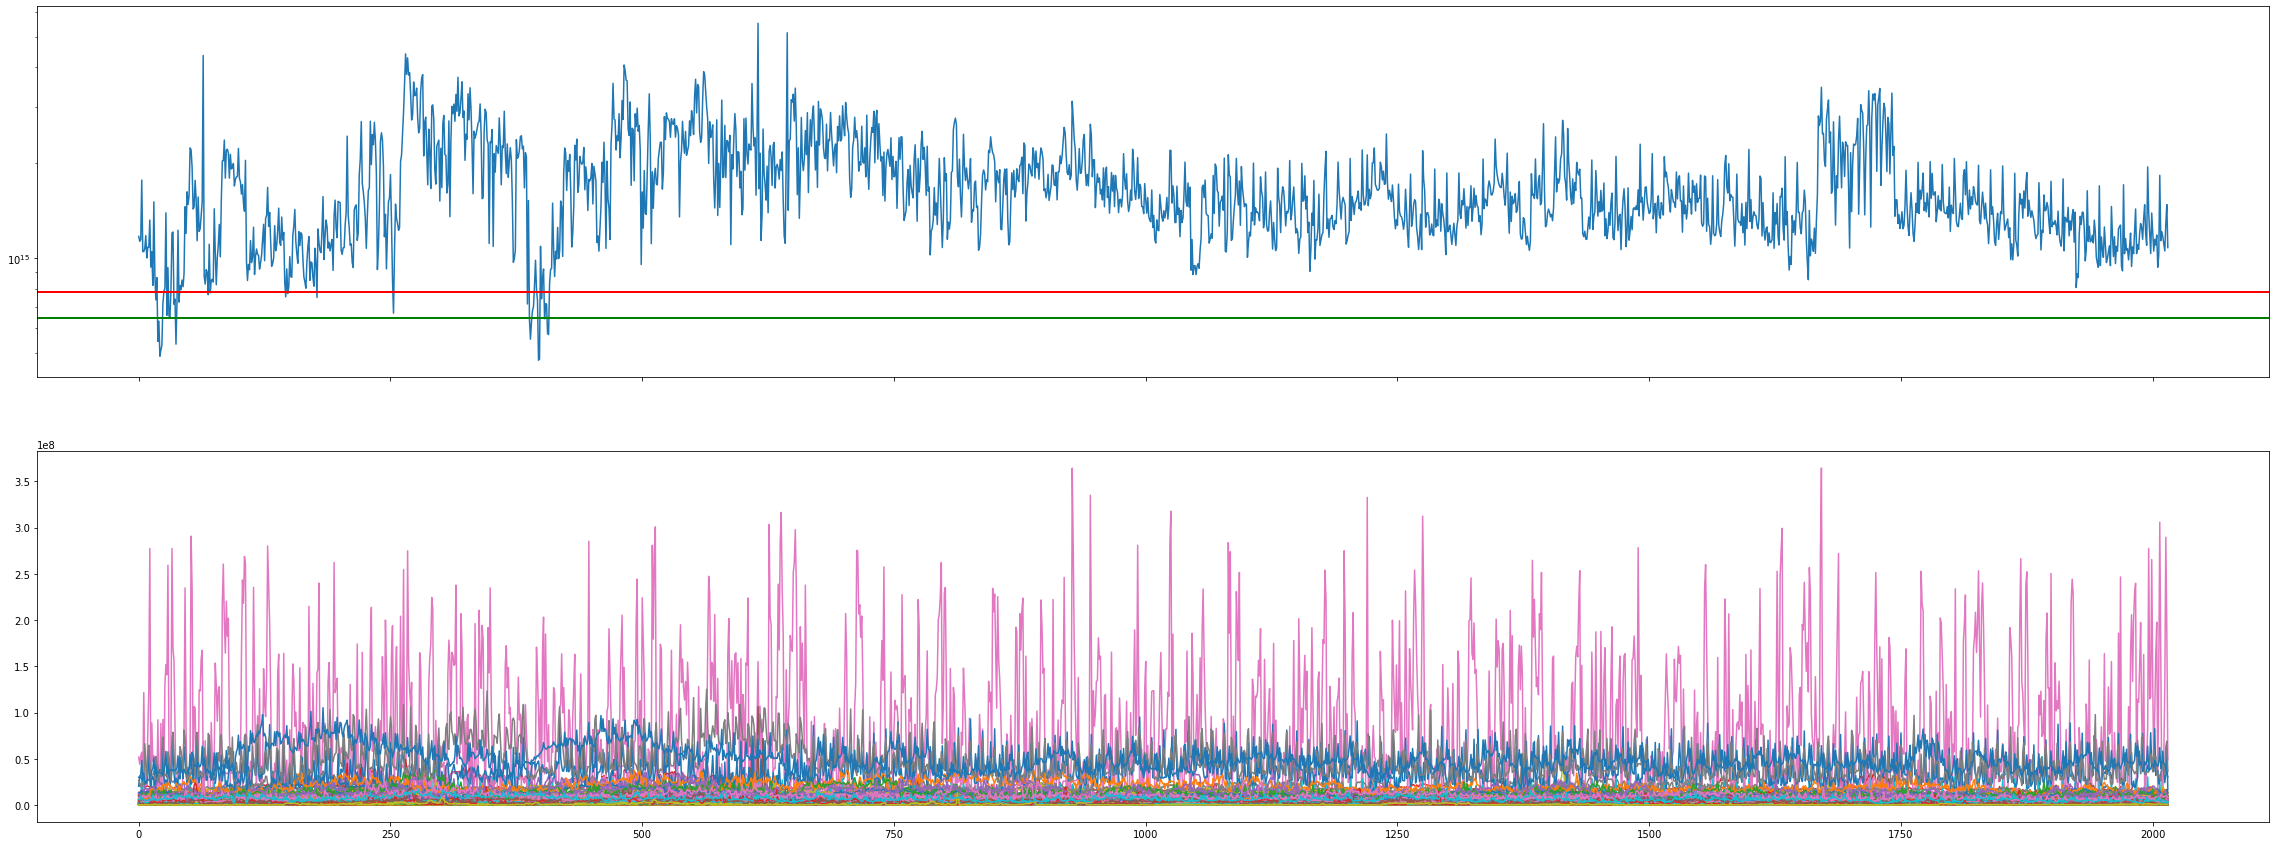

In [195]:
q_plot(X4, X4_resid, 7)

Число выбросов для  $\alpha=0.01$

In [192]:
np.sum([q_stat(X4_resid, t) for t in range(2016)] > q_critical(X4, 7, 0.01))

1980

Число выбросов для $\alpha = 0.05$

In [193]:
np.sum([q_stat(X4_resid, t) for t in range(2016)] > q_critical(X4, 7, 0.05))

2002

## Выводы
Если честно, я вероятно не полностью понимаю ситуацию:

* из реализации выглядит, что почти все наблюдения для 4 недели почти все наблюдения находятся за порогом, который построен на осное PCA по 2 неделе.

* если следовать первоначальной логике - это говорит нам, что 4 неделя принципиально от второй отличаются

* для недели X2 и X3 есть некий список моментов, для которых значения выше порога - их можно считать выбросами как в задаче поиска разделения на 2 класса без учителя

# Часть 2. Детектирование аномалий на основе One-Class SVM
Рассмотрим задачу детектирование сетевых атак: Intrusion Detection. Будем использовать данные из KDD Cup 1999 Competition ( http://kdd.ics.uci.edu/databases/kddcup99/task.html). Полная база данных содержит около пяти миллионов записей о сетевых соединениях и различных типах атаках. Mы будем работать подвыборкой в 10% от оригинального датасета, отсутствие атаки обозначено как “normal”, а ее наличие — как “abnormal”.

In [77]:
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split

from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD as TSVD

from scipy.special import expit
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

import pyarrow.parquet as pq
import pickle

Считаем данные:

In [78]:
train = pd.read_csv('intrusion/train')
test = pd.read_csv('intrusion/test', delimiter = ';')
X_test = np.array(test.drop(test.columns[[0, 1, 2, 3]], axis=1))
np.save('test_np', X_test)

In [79]:
train.head(n=10)

,0,tcp,http,SF,181,5450,0.1,0.2,0.3,0.4,...,9.1,1.00.1,0.00.6,0.11.1,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,210,624,0,0,0,0,...,109,1.0,0.0,0.06,0.05,0.0,0.0,0.0,0.0,normal.


В выборке метками $\{-1, 1\}$ обозначены аномальныe и нормальные наблюдения. Посмотрим на гистограмму классов:

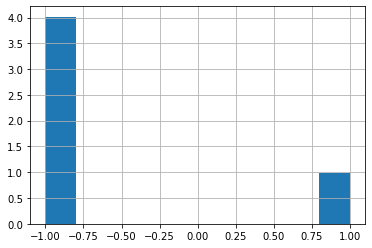

In [80]:
y_train = (train['normal.'] == 'normal.') * 2 - 1
plt.hist(y_train, density=True);
plt.grid(True)

"Отрежем" не нужные для обучения колонки и целевую переменную.

In [81]:
X_train = train.drop(train.columns[[0, 1, 2, 3, 41]], axis=1)
y_train = y_train

In [82]:
y_train.value_counts()/len(y_train)

-1    0.803091
 1    0.196909
Name: normal., dtype: float64

Посмотрим на признаки. Самый простой способ оценить их качество, это посчитать дисперсию:

In [83]:
X_train.var()

181        9.765770e+11
5450       1.091644e+09
0.1        4.453072e-05
0.2        1.817249e-02
0.3        3.036300e-05
0.4        6.116857e-01
0.5        2.408584e-04
1          1.262687e-01
0.6        3.233984e+00
0.7        1.113194e-04
0.8        6.072508e-05
0.9        4.051043e+00
0.10       9.296040e-03
0.11       1.214409e-04
0.12       1.330916e-03
0.13       0.000000e+00
0.14       0.000000e+00
0.15       1.384664e-03
8          4.543170e+04
8.1        6.067489e+04
0.00       1.449456e-01
0.00.1     1.451739e-01
0.00.2     5.364954e-02
0.00.3     5.389232e-02
1.00       1.506913e-01
0.00.4     6.757756e-03
0.00.5     2.027708e-02
9          4.191872e+03
9.1        1.124453e+04
1.00.1     1.687412e-01
0.00.6     1.193758e-02
0.11.1     2.316586e-01
0.00.7     1.775183e-03
0.00.8     1.448513e-01
0.00.9     1.450999e-01
0.00.10    5.317162e-02
0.00.11    5.296467e-02
dtype: float64

In [84]:
X_train.shape

(494020, 37)

Видим, что есть два константных признака. Их можно удалить:

In [85]:
idx = np.where(X_train.var() == 0)[0]
cols = X_train.columns[idx]
X_train.drop(cols, axis=1, inplace=True)

Следующее, что можно сделать, это посмотреть попарные корреляции признаков:

<Figure size 360x360 with 0 Axes>

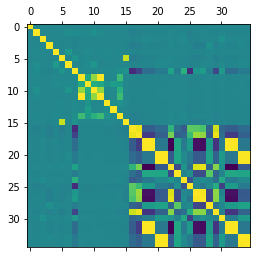

In [86]:
plt.figure(figsize=(5,5));
plt.matshow(X_train.corr());

Такая структура обещает эффективное снижение размерности.

### Задание 1 [1 балл] <a id="task2_1"></a>
Оцените с помощью randomized SVD количество компонент достаточных для сжатия и дальнейшего ускорения обучения. (randomized SVD - быстрый способ оценки количества компонент)

In [87]:
def broken_stick_pc_number_select_rand_svd(X):
    dims = X.shape[1]
    X_mean = np.mean(X, axis=0)
    U, s, V = randomized_svd(X - X_mean, dims)
    
    s = s ** 2 / float(np.sum(s ** 2))
    broken_stick = np.array([np.sum(1.0 / np.arange(1, dims+1)[i:]) for i in range(dims)]) / dims
    return s > broken_stick

In [88]:
X_train_array = np.array(X_train)
broken_stick_pc_number_select_rand_svd(X_train_array)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

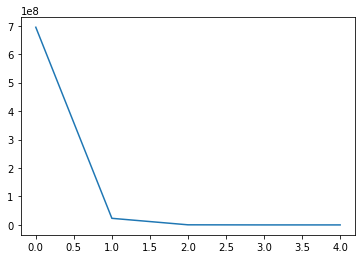

In [89]:
look_on_components =  5
U, Sigma, VT = randomized_svd(X_train_array, look_on_components)
plt.plot(Sigma);

In [90]:
tranc_transf_svd = TSVD(n_components=1)
tranc_transf_svd.fit(X_train)

print(1, tranc_transf_svd.explained_variance_ratio_.sum())
tranc_transf_svd = TSVD(n_components=1)
tranc_transf_svd.fit(X_train)
print(5, tranc_transf_svd.explained_variance_ratio_.sum())

1 0.9988832972283146
5 0.9988832972283146


методом broken_stick и визуально видим, что одного компонента достаточно, действительно, даже 1 компонента объясняет 99,8% дисперсии. Пока предположим, что нас устраивает уменьшение размерности, которое мы получим, взяв 5 и возьмем 5. Если будет проблема с расчетом - сократим.

### Задание 2 [1 балл] <a id="task2_2"></a>

Выберите количество компонент для сжатия и примените **truncated SVD**

In [91]:
model =  TSVD(n_components=5)
X_train_proj =  model.fit_transform(X_train)

Для 1 и 2 компонента покажем, что получается графически

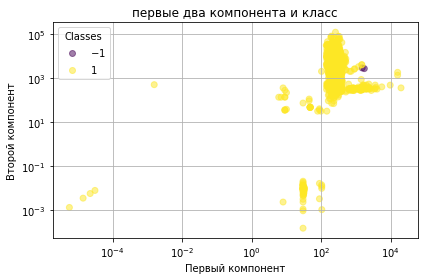

In [46]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_train_proj[:3000,0], X_train_proj[:3000,1], c =y_train[:3000], alpha=0.5, label = 'type')

ax.set_xlabel('Первый компонент')
ax.set_ylabel('Второй компонент')
ax.set_title('первые два компонента и класс')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True)
ax.legend(*scatter.legend_elements(), title="Classes")
fig.tight_layout()

plt.show()

### Задание 3 [3 балла] <a id="task2_3"></a>

Проведите подбор параметров $\nu$ и $\gamma$ для модели OneClassSVM.

Подбор сразу двух параметров может быть затруднен с вычислительной точки зрения (занимает много времени на слабых ПК). В таком случае возможны два выхода:

1) Проводить раздельный подбор гиперпараматров. Сначала поиск по $\nu$, затем при оптимальном $\nu_{opt}$ провести поиск по $\gamma$

2) Уменьшить размер датасета

Поиск параметров предллагается провести в следующей области параметров:

$\nu$: [0.5,1]

$\gamma$: [0.1, 1]


In [92]:
subsample_N = 50000
small_id = np.random.choice(range(X_train_proj.shape[0]), subsample_N)

In [93]:
# количество обьектов для сокращения выборки
# перед уменьшением выборки дайте шанс обучению на полном датасете
# subsample_N = X_train_proj.shape[0] # вместо этого укажите свое N


X_subsample = X_train_proj[small_id]
y_subsample = y_train[small_id]

print(X_train_proj.shape)
print(X_subsample.shape)

(494020, 5)
(50000, 5)


In [95]:
subsample_Nsmall = 10000
small_id_small = np.random.choice(range(X_train_proj.shape[0]), subsample_Nsmall)
X_subsamplesmall = X_train_proj[small_id_small]
y_subsamplesmall = y_train[small_id_small]

print(X_train_proj.shape)
print(X_subsamplesmall.shape)

(494020, 5)
(10000, 5)


#### Проведем поиск по первому параметру $\nu$:

In [96]:
scores = {'accuracy_score': make_scorer(accuracy_score),}

model =  OneClassSVM(kernel='rbf')

grid = {
    'nu':  np.linspace(0.5,1,num=20)
}

search = GridSearchCV(model, grid, scoring=scores,
                      n_jobs=-1, cv=2,
                      refit='accuracy_score', verbose=2)

search.fit(X_subsamplesmall, y_subsamplesmall)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


GridSearchCV(cv=2, estimator=OneClassSVM(), n_jobs=-1,
             param_grid={'nu': array([0.5       , 0.52631579, 0.55263158, 0.57894737, 0.60526316,
       0.63157895, 0.65789474, 0.68421053, 0.71052632, 0.73684211,
       0.76315789, 0.78947368, 0.81578947, 0.84210526, 0.86842105,
       0.89473684, 0.92105263, 0.94736842, 0.97368421, 1.        ])},
             refit='accuracy_score',
             scoring={'accuracy_score': make_scorer(accuracy_score)},
             verbose=2)

#### Построим результаты валидации:

nu:      [0.5 0.5263157894736842 0.5526315789473684 0.5789473684210527
 0.6052631578947368 0.631578947368421 0.6578947368421053
 0.6842105263157895 0.7105263157894737 0.7368421052631579
 0.763157894736842 0.7894736842105263 0.8157894736842105
 0.8421052631578947 0.868421052631579 0.8947368421052632
 0.9210526315789473 0.9473684210526315 0.9736842105263157 1.0]
scores:  [0.5183 0.3248 0.5024 0.4985 0.4943 0.7181 0.4844 0.4789 0.4752 0.67
 0.4669 0.7146 0.709  0.703  0.7116 0.705  0.7028 0.7357 0.7881 0.8064]


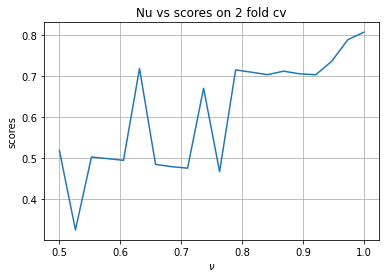

In [98]:
plt.plot(search.cv_results_['param_nu'].data, search.cv_results_['mean_test_accuracy_score'])
plt.title('Nu vs scores on 2 fold cv')
plt.xlabel(r'$\nu$')
plt.ylabel('scores')
plt.grid()

print("nu:     ", search.cv_results_['param_nu'].data)
print("scores: ", search.cv_results_['mean_test_accuracy_score'])

Выберите $\nu$, обеспечивающее наибольший score на кроссвалидации, за исключением $\nu=1$, т.к. это противоречит физическому смыслу задачи

In [105]:
datasm = {'nu': search.cv_results_['param_nu'].data, 
        'score' : search.cv_results_['mean_test_accuracy_score']}
score = pd.DataFrame.from_dict(datasm)
score

,nu,score
0,0.5,0.5183
1,0.526316,0.3248
2,0.552632,0.5024
3,0.578947,0.4985
4,0.605263,0.4943
5,0.631579,0.7181
6,0.657895,0.4844
7,0.684211,0.4789
8,0.710526,0.4752
9,0.736842,0.6700


In [123]:
nu_opt = score.iloc[score[score.nu < 0.8].score.argmax()]
print(nu_opt)

nu       0.631579
score      0.7181
Name: 5, dtype: object


#### если бы мы подбирали отдельно два параметра, я бы перешел дальше к подбору второго, но в следующем разделе я посмотрю одновременный перебор и гаммы и ню, используя HalvingGridSearchCV

Теперь необходимо подобрать $\gamma$. Оптимальнее конечно было бы подбирать сразу оба параметра, но если это не возможно для ваших ресурсов в силу вычислительной сложности, то проведите отдельный поиск $\gamma$ при найденном ранее $\nu_{opt}$.

# Задание 
+ Используя кроссвалидацию оценить качество определения аномальных наблюдений с помощью обученной модели One-Class SVM 
+ Исследовать зависимость этого качества от параметров метода (ширина ядра, доля выбросов в модели, задаваемая параметром $\nu$)

In [72]:
model =  OneClassSVM(kernel='rbf')

grid = {
    'nu':  np.linspace(0.5,0.8,num=20),
    'gamma':  np.linspace(0.1,1,num=30)
}

search_two = HalvingGridSearchCV(model, grid, factor=2, scoring='accuracy',
                      n_jobs=-1, random_state=0, verbose=2).fit(X_subsample, y_subsample)

search_two.best_params_ 

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 97
max_resources_: 50000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 600
n_resources: 97
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
----------
iter: 1
n_candidates: 300
n_resources: 194
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
----------
iter: 2
n_candidates: 150
n_resources: 388
Fitting 5 folds for each of 150 candidates, totalling 750 fits
----------
iter: 3
n_candidates: 75
n_resources: 776
Fitting 5 folds for each of 75 candidates, totalling 375 fits
----------
iter: 4
n_candidates: 38
n_resources: 1552
Fitting 5 folds for each of 38 candidates, totalling 190 fits
----------
iter: 5
n_candidates: 19
n_resources: 3104
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 6
n_candidates: 10
n_resources: 6208
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 7
n_candidates: 5
n_

{'gamma': 0.6275862068965516, 'nu': 0.7526315789473685}

{'gamma': 0.6275862068965516, 'nu': 0.7526315789473685}

In [74]:
search_two.cv_results_

{'iter': array([0, 0, 0, ..., 8, 9, 9]),
 'n_resources': array([   97,    97,    97, ..., 24832, 49664, 49664]),
 'mean_fit_time': array([3.79829407e-03, 4.39782143e-03, 8.79507065e-03, ...,
        1.68829727e+02, 6.59442805e+02, 7.31230640e+02]),
 'std_fit_time': array([7.48468466e-04, 2.80072698e-03, 1.06224600e-02, ...,
        2.40514223e+01, 1.49111159e+02, 6.74442663e+01]),
 'mean_score_time': array([1.59864426e-03, 1.19905472e-03, 1.79872513e-03, ...,
        7.13492857e+01, 2.67641575e+02, 2.58850641e+02]),
 'std_score_time': array([4.89726350e-04, 3.99689827e-04, 3.99756556e-04, ...,
        7.36518357e+00, 7.45340205e+01, 7.65731106e+01]),
 'param_gamma': masked_array(data=[0.1, 0.1, 0.1, ..., 1.0, 0.6275862068965516, 1.0],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_nu': masked_array(data=[0.5, 0.5157894736842106, 0.531578947368421, ..., 0.8,
                    0.7526315789473685, 0.8],
   

In [87]:
# your code here
print("gamma:     ", search_two.cv_results_['param_gamma'].data)
print("nu:     ", search_two.cv_results_['param_nu'].data)

print("scores: ", search_two.cv_results_['mean_test_score'])
print("iter: ", search_two.cv_results_['iter'])


gamma:      [0.1 0.1 0.1 ... 1.0 0.6275862068965516 1.0]
nu:      [0.5 0.5157894736842106 0.531578947368421 ... 0.8 0.7526315789473685 0.8]
scores:  [0.55789474 0.55789474 0.37894737 ... 0.80443012 0.8061619  0.8061619 ]
iter:  [0 0 0 ... 8 9 9]


In [82]:
max(search_two.cv_results_['mean_test_score'])

0.8368421052631578

In [135]:
data = {'gamma': search_two.cv_results_['param_gamma'].data, 
        'mu': search_two.cv_results_['param_nu'].data, 
        'score' : search_two.cv_results_['mean_test_score'], 
        'iter' : search_two.cv_results_['iter']}
mu_gamma_df = pd.DataFrame.from_dict(data)
mu_gamma_df.to_parquet("mu_gamma_df.parquet", engine="pyarrow")


,gamma,mu,score,iter
0,0.100000,0.500000,0.557895,0
1,0.100000,0.515789,0.557895,0
2,0.100000,0.531579,0.378947,0
3,0.100000,0.547368,0.600000,0
4,0.100000,0.563158,0.452632,0
...,...,...,...,...
1197,0.689655,0.768421,0.804430,8
1198,0.627586,0.752632,0.804430,8
1199,1.000000,0.800000,0.804430,8
1200,0.627586,0.752632,0.806162,9


In [8]:
mu_gamma_df = pd.read_parquet("mu_gamma_df.parquet", engine="pyarrow")
mu_gamma_df


,gamma,mu,score,iter
0,0.100000,0.500000,0.557895,0
1,0.100000,0.515789,0.557895,0
2,0.100000,0.531579,0.378947,0
3,0.100000,0.547368,0.600000,0
4,0.100000,0.563158,0.452632,0
...,...,...,...,...
1197,0.689655,0.768421,0.804430,8
1198,0.627586,0.752632,0.804430,8
1199,1.000000,0.800000,0.804430,8
1200,0.627586,0.752632,0.806162,9


In [9]:
mu_gamma_df_last_iter = mu_gamma_df.sort_values('iter', ascending=False).groupby(['gamma', 'mu']).first().reset_index()

## выведем значение accuracy для всех $\nu$ и $\gamma$

In [47]:
allscores = mu_gamma_df_last_iter.pivot(index="gamma", columns="mu")['score']

0.8079742247281514

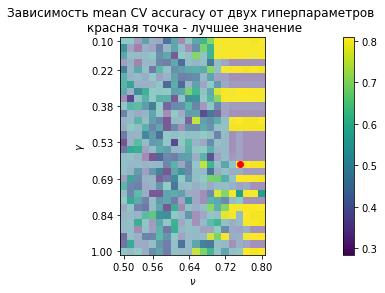

best params {'gamma': 0.6275862068965516, 'nu': 0.7526315789473685}


In [76]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors
ax = plt.subplot()
im = ax.imshow(mu_gamma_df_last_iter.pivot(index="gamma", columns="mu")['score'], 
               alpha=expit(mu_gamma_df_last_iter.pivot(index="gamma", columns="mu")['iter'])/expit(10))
divider = make_axes_locatable(ax)
plt.colorbar(plt.cm.ScalarMappable(norm = colors.Normalize(allscores.min().min(), allscores.max().max())), ax=ax)

positions = (0, 4, 9, 14, 19)
positionsy = (0, 4, 9, 14, 19, 24, 29)
      
y_labels = ['{:.2f}'.format(np.linspace(0.1,1,num=30)[i]) for i in positionsy]

labels = ['{:.2f}'.format(np.linspace(0.5,0.8,num=20)[i]) for i in positions]
ax.set_xticks(positions)
ax.set_xticklabels(labels)

ax.set_yticks(positionsy)
ax.set_yticklabels(y_labels)

bestparams = {'gamma': 0.6275862068965516, 'nu': 0.7526315789473685}
x = (bestparams['nu'] - 0.5) / 0.3 * 19
y = (bestparams['gamma'] - 0.1) / 0.9 * 29

plt.scatter(x,y,color='r')

ax.set(xlabel=r'$\nu$', ylabel=r'$\gamma$',
       title='Зависимость mean CV accuracy от двух гиперпараметров \n красная точка - лучшее значение')

plt.savefig('heatmap_nu_gamma.png')
plt.show()

print('best params', bestparams)

дополнительно на этом графике число итераций алгоритма выведено прозрачностью. Для большей наглядности, выведем только число итераций, чтобы понять, какие наиболее плохие регионы пространства гиперпараметров откидывались раньше

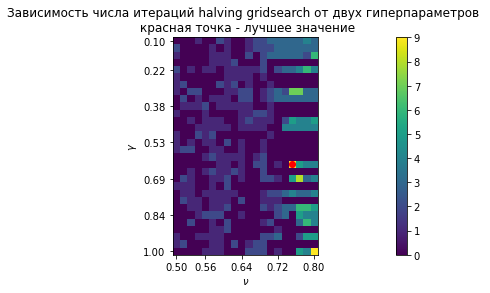

In [75]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors
ax = plt.subplot()
im = ax.imshow(mu_gamma_df_last_iter.pivot(index="gamma", columns="mu")['iter'])
divider = make_axes_locatable(ax)
plt.colorbar(plt.cm.ScalarMappable(norm = colors.Normalize(0, 9)), ax=ax)

positions = (0, 4, 9, 14, 19)
positionsy = (0, 4, 9, 14, 19, 24, 29)
      
y_labels = ['{:.2f}'.format(np.linspace(0.1,1,num=30)[i]) for i in positionsy]

labels = ['{:.2f}'.format(np.linspace(0.5,0.8,num=20)[i]) for i in positions]
ax.set_xticks(positions)
ax.set_xticklabels(labels)

ax.set_yticks(positionsy)
ax.set_yticklabels(y_labels)

bestparams = {'gamma': 0.6275862068965516, 'nu': 0.7526315789473685}
x = (bestparams['nu'] - 0.5) / 0.3 * 19
y = (bestparams['gamma'] - 0.1) / 0.9 * 29

plt.scatter(x,y,color='r')

ax.set(xlabel=r'$\nu$', ylabel=r'$\gamma$',
       title='Зависимость числа итераций halving gridsearch от двух гиперпараметров \n красная точка - лучшее значение')

plt.savefig('heatmap_iter.png')
plt.show()


### выводы

Мы получили примерно следующую зависимость:

* Лучая точность достигается для параметров {'gamma': 0.6275862068965516, 'nu': 0.7526315789473685} и за границей $\nu > 0.8$
* точность растет в среднем при росте $\nu$ и при приближении $\gamma$ к 0,5
* Для более высоких значений, где происходит больше итераций, $\nu > 0.7 $, связь точности с $\gamma$ нелинейна